In [14]:
import numpy as np
import pandas as pd
import sklearn
from sklearn.model_selection import train_test_split
import time
import matplotlib.pyplot as plt

%matplotlib inline

# NLP
import re
import string
import html
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tokenize import TweetTokenizer
from nltk.stem.wordnet import WordNetLemmatizer
nltk.download('wordnet')
nltk.download('stopwords')

from symspellpy.symspellpy import SymSpell, Verbosity

# KERAS / TF
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ['CUDA_VISIBLE_DEVICES'] = ''
import keras.backend as K
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model, Sequential
from keras.layers import Dense, Flatten, LSTM, Conv1D, MaxPooling1D, Dropout, Activation, Bidirectional, concatenate, \
                         CuDNNLSTM, CuDNNGRU, SpatialDropout1D, GlobalAveragePooling1D, GlobalMaxPooling1D, Input, \
                         Flatten, GRU
from keras.layers.embeddings import Embedding
#print("GPUs: " + str(K.tensorflow_backend._get_available_gpus()))

# Flags
balance_dataset = False              # If true, it under-samples the training dataset to get same amount of labels
use_pretrained_embeddings = True     # If true, it enables the use of GloVe pre-trained Twitter word-embeddings
EDIT_DISTANCE =                      2 # Max edit distance for spelling correction suggestions. Setting this to 3 takes a lot longer to create the sym_spell dictionary

[nltk_data] Downloading package wordnet to /homes/np1815/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /homes/np1815/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


##### ROC AUC & macro-F1 score Printing Callback

##### Tweet Processing Function

In [16]:
def process_tweet(tweet,
                  remove_USER_URL=True, 
                  remove_punctuation=True, 
                  remove_stopwords=True, 
                  remove_HTMLentities=True, 
                  remove_hashtags=True, 
                  appostrophe_handling=True, 
                  lemmatize=True, 
                  trial=False,
                  sym_spell=None,
                  reduce_lengthenings=True,
                  segment_words=True,
                  correct_spelling=True,
                 ):
    """
    This function receives tweets and returns clean word-list
    """
    ### Handle USERS and URLS ################################################
    if remove_USER_URL:
        if trial:
            tweet = re.sub(r'@\w+ ?', '', tweet)
            tweet = re.sub(r'http\S+', '', tweet)
        else:
            tweet = re.sub(r"@USER", "<>", tweet)
            tweet = re.sub(r"URL", "", tweet)
    else:
        if trial:
            tweet = re.sub(r'@\w+ ?', '<usertoken> ', tweet)
            tweet = re.sub(r'http\S+', '<urltoken> ', tweet)
        else:
            tweet = re.sub(r"@USER", "<usertoken>", tweet)
            tweet = re.sub(r"URL", "<urltoken>", tweet)
    
    ### Remove HTML Entiti es #################################################
    if remove_HTMLentities:
        tweet = html.unescape(tweet)
    
    ### REMOVE HASHTAGS? #####################################################
    if remove_hashtags:
        tweet = re.sub(r'#\w+ ?', '', tweet)
    
    ### Convert to lower case: Hi->hi, MAGA -> maga ##########################
    tweet = tweet.lower()
    
    ### Cleaning: non-ASCII filtering, some appostrophes, separation #########
    tweet = re.sub(r"’", r"'", tweet)
    tweet = re.sub(r"[^A-Za-z0-9'^,!.\/+-=@]", " ", tweet)
    tweet = re.sub(r"what's", "what is ", tweet)
    tweet = re.sub(r"\'s", " ", tweet)
    tweet = re.sub(r"\'ve", " have ", tweet)
    tweet = re.sub(r"n't", " not ", tweet)
#     tweet = re.sub(r"i'm", "i am ", tweet)
    tweet = re.sub(r"\'re", " are ", tweet)
    tweet = re.sub(r"\'d", " would ", tweet)
    tweet = re.sub(r"\'ll", " will ", tweet)
    tweet = re.sub(r",", " ", tweet)
    tweet = re.sub(r"\.", " ", tweet)
    tweet = re.sub(r"!", " ! ", tweet)
    tweet = re.sub(r"\/", " ", tweet)
    tweet = re.sub(r"\^", " ^ ", tweet)
    tweet = re.sub(r"\+", " + ", tweet)
    tweet = re.sub(r"\-", " - ", tweet)
    tweet = re.sub(r"\=", " = ", tweet)
    tweet = re.sub(r"(\d+)(k)", r"\g<1>000", tweet)
    tweet = re.sub(r":", " : ", tweet)
    tweet = re.sub(r" e g ", " eg ", tweet)
    tweet = re.sub(r" b g ", " bg ", tweet)
    tweet = re.sub(r" u s ", " american ", tweet)
    tweet = re.sub(r"\0s", "0", tweet)
    tweet = re.sub(r" 9 11 ", "911", tweet)
    tweet = re.sub(r"e - mail", "email", tweet)
    tweet = re.sub(r"j k", "jk", tweet)
    tweet = re.sub(r"\s{2,}", " ", tweet)

    ### Remove Punctuation ###################################################
    if remove_punctuation:
        translator = str.maketrans('', '', ''.join(list(set(string.punctuation) - set("'"))))
        tweet = tweet.translate(translator)
    
    # Tokenize sentence for further word-level processing
    tokenizer  = TweetTokenizer()
    words = tokenizer.tokenize(tweet)
    
    ### Apostrophe handling:    you're   -> you are  ########################
    APPO = {"aren't" : "are not", "can't" : "cannot", "couldn't" : "could not", "didn't" : "did not", "doesn't" : "does not", "don't" : "do not", "hadn't" : "had not", "hasn't" : "has not", "haven't" : "have not", "he'd" : "he would", "he'll" : "he will", "he's" : "he is", "i'd" : "I would", "i'd" : "I had", "i'll" : "I will", "i'm" : "I am", "isn't" : "is not", "it's" : "it is", "it'll":"it will", "i've" : "I have", "let's" : "let us", "mightn't" : "might not", "mustn't" : "must not", "shan't" : "shall not", "she'd" : "she would", "she'll" : "she will", "she's" : "she is", "shouldn't" : "should not", "that's" : "that is", "there's" : "there is", "they'd" : "they would", "they'll" : "they will", "they're" : "they are", "they've" : "they have", "we'd" : "we would", "we're" : "we are", "weren't" : "were not", "we've" : "we have", "what'll" : "what will", "what're" : "what are", "what's" : "what is", "what've" : "what have", "where's" : "where is", "who'd" : "who would", "who'll" : "who will", "who're" : "who are", "who's" : "who is", "who've" : "who have", "won't" : "will not", "wouldn't" : "would not", "you'd" : "you would", "you'll" : "you will", "you're" : "you are", "you've" : "you have", "'re": " are", "wasn't": "was not", "we'll":" will", "didn't": "did not"}
    if appostrophe_handling:
        words = [APPO[word] if word in APPO else word for word in words]
    
    tweet = ' '.join(words)
    words = tokenizer.tokenize(tweet)
    
    ### Lemmatisation:          drinking -> drink ###########################
    if lemmatize:
        lemmatizer = WordNetLemmatizer()
        words = [lemmatizer.lemmatize(word, "v") for word in words]
    
    ### Remove stop words:      is, that, the, ... ##########################
    if remove_stopwords:
        eng_stopwords = set(stopwords.words("english"))
        words = [w for w in words if not w in eng_stopwords]
        
    ### Reduce lengthening:    aaaaaaaaah -> aah, bleeeeerh -> bleerh #################
    if reduce_lengthenings:
        pattern = re.compile(r"(.)\1{2,}")
        words = [pattern.sub(r"\1\1", w) for w in words]

    if sym_spell and (segment_words or correct_spelling):

        ### Segment words:    thecatonthemat -> the cat on the mat ####################
        if segment_words:
            words = [sym_spell.word_segmentation(word).corrected_string for word in words]

        ### Correct spelling: birberals -> liberals ######################
        if correct_spelling:
            def correct_spelling_for_word(word):
                suggestions = sym_spell.lookup(word, Verbosity.TOP, EDIT_DISTANCE)

                if len(suggestions) > 0:
                    return suggestions[0].term
                return word
            
            words = [correct_spelling_for_word(word) for word in words]
        
    clean_tweet = " ".join(words)
    clean_tweet = re.sub("  "," ",clean_tweet)
    clean_tweet = clean_tweet.lower()
    
    return clean_tweet

In [17]:
from random import shuffle

def under_sample(X, y):
    idx_0 = np.where(y==0)[0].tolist()
    idx_1 = np.where(y==1)[0].tolist()

    N = np.min([len(idx_0), len(idx_1)])
    idx = idx_0[:N] + idx_1[:N]
    shuffle(idx)
    
    X = X[idx].reshape(-1)
    y = y[idx].reshape(-1,1)
    
    return X, y

## 1. LOAD DATA AND PRE-PROCESS

In [18]:
params = dict(remove_USER_URL=True,
              remove_stopwords=False,
              remove_HTMLentities=True,
              remove_punctuation=True,
              appostrophe_handling=True,
              lemmatize=True,
              reduce_lengthenings=True,
              segment_words=False,
              correct_spelling=False
             )

In [19]:
####################################################################################################
##   GloVe EMBEDDINGS     ##########################################################################
####################################################################################################
import pickle
from pathlib import Path

embed_size     = 100

if use_pretrained_embeddings:
    path = Path("embedding_index.pkl")
    if path.is_file():
        with open("embedding_index.pkl", "rb") as f:
            embedding_index = pickle.load(f)
    else:
        # Download embeddings from https://nlp.stanford.edu/projects/glove/
        #                          https://nlp.stanford.edu/data/glove.twitter.27B.zip
        embedding_path = "glove.twitter.27B.100d.txt"

        def get_coefs(word,*arr):
            return word, np.asarray(arr, dtype='float32')

        # Construct embedding table (word -> vector)
        print("Building embedding index [word->vector]", end="\n")
        t0 = time.time()
        embedding_index = dict(get_coefs(*o.strip().split(" ")) for o in open(embedding_path, encoding="utf8"))
        
        with open("embedding_index.pkl", "wb") as f:
            pickle.dump(embedding_index, f)
            
        print(" - Done! ({:0.2f}s)".format(time.time()-t0))
    
sym_spell = None
# if params['correct_spelling'] or params['segment_words']:
#     sym_spell = SymSpell(EDIT_DISTANCE, 7)
#     # For some reason, we have to write out the list of words contained in the embeddings out to a file for sym_spell to read from
#     print("Writing out corpus.txt")
#     with open("corpus.txt", "w") as f:
#         f.write(" ".join(embedding_index.keys()))
#     print("Done!")

#     print("Creating sym_spell dictionary")
#     sym_spell.create_dictionary("corpus.txt")
#     print("Done!")

print("Loading training data")
df_a = pd.read_csv('start-kit/training-v1/offenseval-training-v1.tsv',sep='\t')
df_a_trial = pd.read_csv('start-kit/trial-data/offenseval-trial.txt', sep='\t')
print("Done!")

Loading training data
Done!


In [20]:
print("Preprocessing...")

X = df_a['tweet'].apply(lambda x: process_tweet(x, **params, trial=False, sym_spell=sym_spell)).values;
y = df_a['subtask_a'].replace({'OFF': 1, 'NOT': 0}).values;
class_weights = sklearn.utils.class_weight.compute_class_weight('balanced', np.unique(y), y.reshape(-1))

X_trial = df_a_trial['tweet'].apply(lambda x: process_tweet(x, **params, trial=True, sym_spell=sym_spell)).values;
y_trial = df_a_trial['subtask_a'].replace({'OFF': 1, 'NOT': 0}).values;
print("Done!")

if balance_dataset:
    X, y = under_sample(X, y)


print("EXAMPLES OF PROCESSED TWEETS [train/trial]")
print("_________________________________________________________________________________________________________")
for id in range(10, 15):
    print("Un-processed:  " + df_a['tweet'][id])
    print("Processed:     " + X[id])
    print("")
print("_________________________________________________________________________________________________________")
for id in range(10, 15):
    print("Un-processed:  " + df_a_trial['tweet'][id])
    print("Processed:     " + X_trial[id])
    print("")

Preprocessing...
Done!
EXAMPLES OF PROCESSED TWEETS [train/trial]
_________________________________________________________________________________________________________
Un-processed:  @USER @USER @USER It’s not my fault you support gun control
Processed:     it not my fault you support gun control

Un-processed:  @USER What’s the difference between #Kavanaugh and @USER   One of these men admitted to groping a 15 year old girl years ago.  The other is going to be #confirmed to the SCJ   #DemsareFrauds #DemsAreDone   #WalkAwayDemocrats2018 #redwave #VoteRedSaveAmerica #trumptrain #MAGA URL
Processed:     what be the difference between and one of these men admit to grope a 15 year old girl years ago the other be go to be to the scj

Un-processed:  @USER you are a lying corrupt traitor!!! Nobody wants to hear anymore of your lies!!! #DeepStateCorruption URL
Processed:     you be a lie corrupt traitor nobody want to hear anymore of your lie

Un-processed:  @USER @USER @USER It should sca

#### Build Vocabulary by Hand (Not of any actual use, only to print size and unique word count)

In [21]:
def get_tokenized_corpus(corpus):
    tokenized_corpus = []
    for sentence in corpus:
        tokenized_sentence = []
        for token in sentence.split(' '): 
            tokenized_sentence.append(token)
        tokenized_corpus.append(tokenized_sentence)
    return tokenized_corpus


tokenized_corpus = get_tokenized_corpus(X)
tokenized_corpus

vocabulary = []
token_count = 0
for sentence in tokenized_corpus:
    for token in sentence:
        token_count += 1
        if token not in vocabulary:
            vocabulary.append(token)
            
print("This corpus contains {} tokens, of which {} are unique. I.e. avg of {:0.2f} words per tweet.".format(token_count, len(vocabulary), token_count/df_a.shape[0]))

This corpus contains 257435 tokens, of which 14477 are unique. I.e. avg of 19.44 words per tweet.


## Prepare Data for Model
#### Tokenize tweets  |  Turn into Index sequences  |  Pad sequences to max_length  |  (optional) Use word embeddings

##### GloVe Twitter word-embedding how to:
1. Read embeddings and build a [word -> vector] dictionary
2. Use tokenizer [word -> index] dictionary to iterate through all words in vocab
3. For each word in vocab (iterate over [word -> index] tokenizer dictionary): 
    - Attempt to get word's embedding vector from GloVe Twitter [word -> vector]
    - If word is in embedding's vocabulary: add the vector to the embedding matrix at the right index
    - If not, do not do anything (respective vector will be [0, 0, 0, ..., 0]

Embedding matrix will be of size (nb_words + 1, embedding_dim), this will be loaded into the embeddings layer later

In [22]:
####################################################################################################
##   BUILD VOCABULARY FROM CORPUS   ################################################################
####################################################################################################
max_seq_len    = 50
max_features   = 30000

# Tokenize all tweets
tokenizer = Tokenizer(lower=True, filters='', split=' ')
X_all = list(X) + list(X_trial)
tokenizer.fit_on_texts(X_all)
print(f"Num of unique tokens in tokenizer: {len(tokenizer.word_index)}")

# Get sequences for each dataset
sequences       = tokenizer.texts_to_sequences(X)
sequences_trial = tokenizer.texts_to_sequences(X_trial)

# Pad sequences
X       = pad_sequences(sequences, maxlen = max_seq_len)
X_trial = pad_sequences(sequences_trial, maxlen = max_seq_len)

# Reshape labels
y       = y.reshape(-1,1)
y_trial = y_trial.reshape(-1,1)


Num of unique tokens in tokenizer: 14737


In [23]:
if use_pretrained_embeddings:
    # Build Embedding Matrix
    n_words_in_glove = 0
    n_words_not_in_glove = 0
    words_in_glove = []
    words_not_in_glove = []
    
    word_index = tokenizer.word_index
    nb_words = min(max_features, len(word_index))
    embedding_matrix = np.zeros((nb_words + 1, embed_size))
    print(f"Building embedding matrix {embedding_matrix.shape}", end="")
    for word, i in word_index.items():
        if i >= max_features: continue
        embedding_vector = embedding_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
            n_words_in_glove += 1
            words_in_glove.append(word)
        else:
            n_words_not_in_glove += 1
            words_not_in_glove.append(word)
    print(" - Done!")
    print("This vocabulary has {} unique tokens of which {} are in the embeddings and {} are not".format(len(word_index), n_words_in_glove, n_words_not_in_glove))
    print(f"Words not in Glove: {len(words_not_in_glove)}")

Building embedding matrix (14738, 100) - Done!
This vocabulary has 14737 unique tokens of which 12940 are in the embeddings and 1797 are not
Words not in Glove: 1797


Mean sentence length: 19.4 words
MAX  sentence length: 63 words


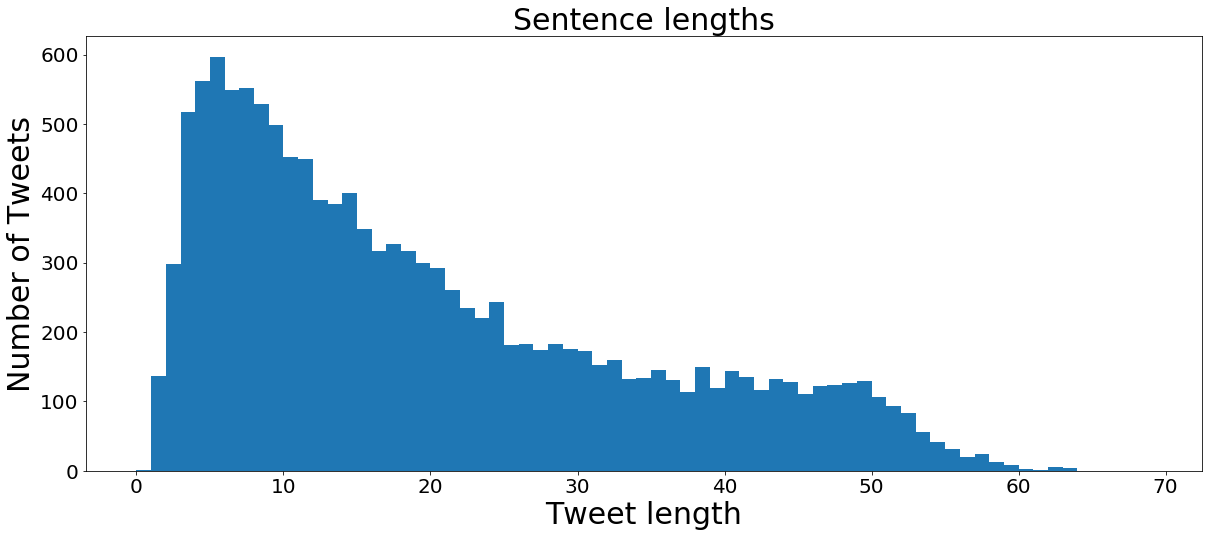

In [27]:
sentence_lengths = [len(tokens) for tokens in sequences]
print("Mean sentence length: {:0.1f} words".format(np.mean(sentence_lengths)))
print("MAX  sentence length: {} words".format(np.max(sentence_lengths)))

fig, ax = plt.subplots(nrows=1, ncols=1)

fig.set_size_inches([20, 8])

ax.set_title('Sentence lengths', fontsize=30)
ax.set_xlabel('Tweet length', fontsize=30)
ax.set_ylabel('Number of Tweets', fontsize=30)
ax.hist(sentence_lengths, bins=list(range(70)))
ax.tick_params(labelsize=20)
fig.savefig("sentence_lenghts.pdf", bbox_inches="tight")


In [30]:
np.unique(y, return_counts=True)

(array([0, 1]), array([8840, 4400]))

# 2. BUILD MODEL & TRAIN

### Define RNN Models

In [ ]:
def build_Bi_GRU_LSTM_CN_model(lr=0.001, lr_decay=0.01, recurrent_units=0, dropout=0.0):
    # Model architecture
    inputs = Input(shape = (max_seq_len,), name="Input")
    
    emb = Embedding(nb_words+1, embed_size, trainable=train_embeddings, name="WordEmbeddings")(inputs)
    emb = SpatialDropout1D(dropout)(emb)

    gru_out  = Bidirectional(CuDNNGRU(RECURRENT_UNITS, return_sequences = True), name="Bi_GRU")(emb)
    gru_out  = Conv1D(32, 4, activation='relu', padding='valid', kernel_initializer='he_uniform')(gru_out)

    lstm_out = Bidirectional(CuDNNLSTM(RECURRENT_UNITS, return_sequences = True), name="Bi_LSTM")(emb)
    lstm_out = Conv1D(32, 4, activation='relu', padding='valid', kernel_initializer='he_uniform')(lstm_out)

    avg_pool1 = GlobalAveragePooling1D(name="GlobalAVGPooling_GRU")(gru_out)
    max_pool1 = GlobalMaxPooling1D(name="GlobalMAXPooling_GRU")(gru_out)

    avg_pool2 = GlobalAveragePooling1D(name="GlobalAVGPooling_LSTM")(lstm_out)
    max_pool2 = GlobalMaxPooling1D(name="GlobalMAXPooling_LSTM")(lstm_out) 

    x = concatenate([avg_pool1, max_pool1, avg_pool2, max_pool2])

    outputs = Dense(1, activation='sigmoid', name="Output")(x)
    
    model = Model(inputs,outputs)
    
    return model, 1

def build_LSTM():
    model = Sequential()
    model.add(Embedding(nb_words+1, embed_size, input_length=max_seq_len, trainable=train_embeddings, name="Embeddings"))
    model.add(SpatialDropout1D(DROPOUT))
    model.add(Bidirectional(LSTM(RECURRENT_UNITS)))
    model.add(Dense(1, activation='sigmoid'))
    return model, 0

def build_CNN_LSTM():
    EMBEDDING_DIM = embed_size
    model = Sequential()
    model.add(Embedding(nb_words+1, EMBEDDING_DIM, input_length=max_seq_len, trainable=train_embeddings, name="Embeddings"))
    model.add(SpatialDropout1D(DROPOUT))
    model.add(Conv1D(64, 4, activation='relu', kernel_initializer='he_uniform'))
    model.add(MaxPooling1D(pool_size=4))
    model.add(Bidirectional(LSTM(RECURRENT_UNITS, dropout=LSTM_DROPOUT, recurrent_dropout=LSTM_DROPOUT)))
    model.add(Dense(1, activation='sigmoid'))
    return model, 0

def build_LSTM_CNN():
    EMBEDDING_DIM = embed_size
    model = Sequential()
    model.add(Embedding(nb_words+1, EMBEDDING_DIM, input_length=max_seq_len, trainable=train_embeddings, name="Embeddings"))
#     model.add(SpatialDropout1D(DROPOUT))
    model.add(Dropout(DROPOUT))
    model.add(Bidirectional(CuDNNLSTM(RECURRENT_UNITS, return_sequences=True)))
#     model.add(Bidirectional(LSTM(EMBEDDING_DIM, return_sequences=True, dropout=LSTM_DROPOUT, recurrent_dropout=LSTM_DROPOUT)))
    model.add(Conv1D(64, kernel_size=2, activation='relu', padding='valid', kernel_initializer='he_uniform'))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))

    return model, 0

### Build and Train

[0.004, 0, 20, 32, 100, 0.4, 0.0]
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Embeddings (Embedding)       (None, 50, 100)           1473800   
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 50, 100)           0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 200)               160800    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 201       
Total params: 1,634,801
Trainable params: 161,001
Non-trainable params: 1,473,800
_________________________________________________________________
Class weights (to address dataset imbalance):


{0: 0.748868778280543, 1: 1.5045454545454546}

Train on 10592 samples, validate on 2648 samples
Epoch 1/20
10592/10592 [==============================] - 19s 2ms/step - loss: 0.5557 - acc: 0.7188 - val_loss: 0.4823 - val_acc: 0.7753

Epoch 00001: val_loss improved from inf to 0.48232, saving model to weights-improvement-01-0.77530-0.48232.hdf5
     - LR: 0.00400 train_auc: 0.6910 - train_F1: 0.7072 - val_auc: 0.6868 - val_F1: 0.7026


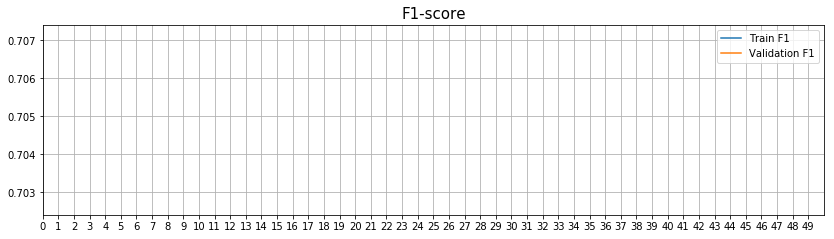




Epoch 2/20
10592/10592 [==============================] - 17s 2ms/step - loss: 0.5066 - acc: 0.7576 - val_loss: 0.4557 - val_acc: 0.7904

Epoch 00002: val_loss improved from 0.48232 to 0.45570, saving model to weights-improvement-02-0.79041-0.45570.hdf5
     - LR: 0.00400 train_auc: 0.7240 - train_F1: 0.7407 - val_auc: 0.7192 - val_F1: 0.7361


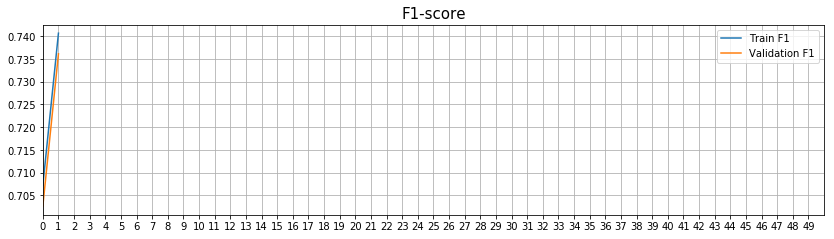




Epoch 3/20
10592/10592 [==============================] - 17s 2ms/step - loss: 0.4809 - acc: 0.7715 - val_loss: 0.4619 - val_acc: 0.7881

Epoch 00003: val_loss did not improve from 0.45570
     - LR: 0.00400 train_auc: 0.7602 - train_F1: 0.7715 - val_auc: 0.7375 - val_F1: 0.7482


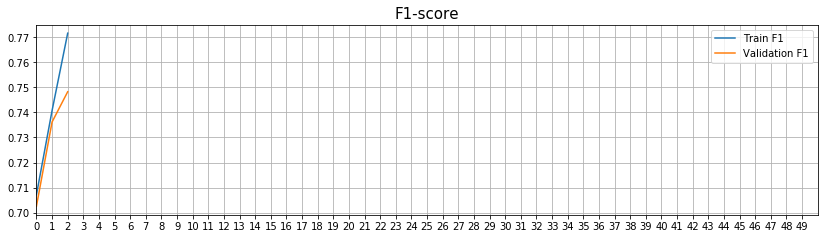




Epoch 4/20
10592/10592 [==============================] - 17s 2ms/step - loss: 0.4704 - acc: 0.7804 - val_loss: 0.4557 - val_acc: 0.7961

Epoch 00004: val_loss improved from 0.45570 to 0.45568, saving model to weights-improvement-04-0.79607-0.45568.hdf5
     - LR: 0.00400 train_auc: 0.7592 - train_F1: 0.7745 - val_auc: 0.7357 - val_F1: 0.7507


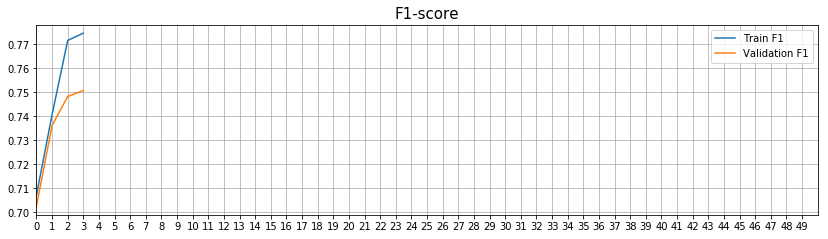




Epoch 5/20
 1792/10592 [====>.........................] - ETA: 12s - loss: 0.4508 - acc: 0.7941

In [ ]:
from keras import optimizers
from keras.callbacks import EarlyStopping, ModelCheckpoint

# SET HYPERPARAMETERS -------------------------------------------------------------------------------------------
LR               = 0.004
LR_DECAY         = 0
EPOCHS           = 20
BATCH_SIZE       = 32
EMBEDDING_DIM    = embed_size
DROPOUT          = 0.4         # Connection drop ratio for CNN to LSTM dropout
LSTM_DROPOUT     = 0.0         # Connection drop ratio for gate-specific dropout
BIDIRECTIONAL    = True
RECURRENT_UNITS  = 100
train_embeddings = not use_pretrained_embeddings
print([LR, LR_DECAY, EPOCHS, BATCH_SIZE, EMBEDDING_DIM, DROPOUT, LSTM_DROPOUT])
#---------------------------------------------------------------------------------------------------------------


# BUILD MODEL --------------------------------------------------------------------------------------------------
# - Can select which architecture to use (simple LSTM works pretty well)
model, embed_idx = build_LSTM()
# model, embed_idx = build_CNN_LSTM()
# model, embed_idx = build_LSTM_CNN()
# model, embed_idx = build_Bi_GRU_LSTM_CN_model(LR, LR_DECAY, RECURRENT_UNITS, DROPOUT)
#---------------------------------------------------------------------------------------------------------------


# OPTIMIZER | COMPILE | EMBEDDINGS -----------------------------------------------------------------------------
optim = optimizers.Adam(lr=LR, decay=LR_DECAY)
model.compile(loss='binary_crossentropy', optimizer=optim, metrics=['accuracy'])
if use_pretrained_embeddings:
    model.layers[embed_idx].set_weights([embedding_matrix])
model.summary()
#---------------------------------------------------------------------------------------------------------------
# X_train, X_val, y_train, y_val = (X, y, X_trial, Y_trial)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y)

# Can change right hand side to (X, y, X_trial, y_trial) or (X_train, Y_train, X_val, Y_val)
# X_train, y_train, X_val, y_val = (X, y, X_train, y_trial)

class_weights = sklearn.utils.class_weight.compute_class_weight('balanced', np.unique(y_train), y_train.reshape(-1))
weights_dict = dict()
for i, weight in enumerate(class_weights):
    weights_dict[i] = weight
print("Class weights (to address dataset imbalance):")
display(weights_dict)


# FIT THE MODEL ------------------------------------------------------------------------------------------------
auc_f1     = ROC_F1(validation_data=(X_val, y_val), training_data=(X_train, y_train), interval=1)
earlystop  = EarlyStopping(monitor='val_loss', patience=15, verbose=1, mode='auto', restore_best_weights=True)
filepath   = "weights-improvement-{epoch:02d}-{val_acc:.5f}-{val_loss:.5f}.hdf5"
checkpoint = ModelCheckpoint(filepath, save_best_only=True, monitor='val_loss', verbose=1, mode='min')

train_history = model.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=BATCH_SIZE, epochs=EPOCHS,
                          verbose=1, class_weight=class_weights, callbacks=[earlystop, checkpoint, auc_f1])
#---------------------------------------------------------------------------------------------------------------

### Evaluate [Training History, Classification Report + Metrics]


In [ ]:
height = 3.5;    width = height*4
n_epochs = 40
# n_epochs = len(train_history.history['loss'])

# # Plot Loss
# plt.figure(figsize=(width,height))
# plt.plot(train_history.history['loss'], label="Train Loss")
# plt.plot(train_history.history['val_loss'], label="Validation Loss")
# plt.xlim([0,n_epochs-1]); plt.xticks(list(range(n_epochs)));   plt.grid(True);   plt.legend()
# plt.title("Loss (Binary Cross-entropy)", fontsize=15)
# plt.show()

# # Plot accuracy
# plt.figure(figsize=(width,height))
# plt.plot(train_history.history['acc'], label="Train Accuracy")
# plt.plot(train_history.history['val_acc'], label="Validation Accuracy")
# plt.xlim([0,n_epochs-1]); plt.xticks(list(range(n_epochs)));   plt.grid(True);   plt.legend()
# plt.title("Accuracy", fontsize=15)
# plt.show()

# Plot F1
plt.figure(figsize=(width,height))
plt.plot(auc_f1.f1s_train, label="Train F1")
plt.plot(auc_f1.f1s_val, label="Validation F1")
plt.xlim([0,n_epochs-1]); plt.xticks(list(range(n_epochs)));   plt.grid(True);   plt.legend()
plt.title("F1-score", fontsize=15)
plt.show()

# # Plot ROC AUC
plt.figure(figsize=(width,height))
plt.plot(auc_f1.aucs_train, label="Train ROC AUC")
plt.plot(auc_f1.aucs_val, label="Validation ROC AUC")
plt.xlim([0,n_epochs-1]); plt.xticks(list(range(n_epochs)));   plt.grid(True);   plt.legend()
plt.legend()
plt.title("ROC AUC", fontsize=15)
plt.show()

##### Confusion matrix & Classication Report ###################################################
import itertools
from sklearn.metrics import confusion_matrix

# def plot_confusion_matrix(cm, classes,
#                           normalize=False,
#                           title='Confusion matrix',
#                           cmap=plt.cm.winter):
#     if normalize:
#         cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
#     plt.imshow(cm, interpolation='nearest', cmap=cmap)
#     plt.title(title, fontsize=30)
#     plt.colorbar()
#     tick_marks = np.arange(len(classes))
#     plt.xticks(tick_marks, classes, fontsize=20)
#     plt.yticks(tick_marks, classes, fontsize=20)
    
#     fmt = '.2f' if normalize else 'd'
#     thresh = cm.max() / 2.

#     for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
#         plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", 
#                  color="white" if cm[i, j] < thresh else "black", fontsize=40)
    
#     plt.tight_layout()
#     plt.ylabel('True label', fontsize=30)
#     plt.xlabel('Predicted label', fontsize=30)

#     return plt

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

X_eval = X_trial
y_eval = y_trial

y_pred = model.predict(X_eval)
y_pred = np.round(y_pred)
print("Validation Accuracy: {:0.2f}%".format(np.sum(y_eval==y_pred)/y_eval.shape[0]*100))

cm = confusion_matrix(y_eval, y_pred)
fig = plt.figure(figsize=(10, 10))
plot = plot_confusion_matrix(cm, classes=['NOT-OFFENSIVE','OFFENSIVE'], normalize=True, title='Confusion matrix')
plt.show()
# print(cm)


from sklearn.metrics import classification_report
print(classification_report(y_eval, y_pred))

## Generate Submission

In [ ]:
model.save("model_A.h5")
params = dict(remove_USER_URL=True,
              remove_stopwords=False,
              remove_HTMLentities=True,
              remove_punctuation=True,
              appostrophe_handling=True,
              lemmatize=True)

df_test = pd.read_csv('../OffensEval_data/test/testset-taska.tsv',sep='\t')
ID = df_test['id']

X_test = df_test['tweet'].apply(lambda x: process_tweet(x, **params, trial=False)).values

sequences_test = tokenizer.texts_to_sequences(X_test)
X_test = pad_sequences(sequences_test, maxlen = max_seq_len)

y_pred = model.predict(X_test)

OFF = y_pred
NOT = 1-y_pred
Y_pred = np.hstack((NOT, OFF))

classes = np.argmax(Y_pred, axis=1).reshape(-1,1)

df_submission = pd.DataFrame()
df_submission['id'] = ID
df_submission['label'] = classes
df_submission['label'] = df_submission['label'].replace({0: 'NOT', 1: 'OFF'})

df_submission.head()
df_submission.to_csv("submission_a/test_a_submission.csv", header=None, index=None)

In [ ]:
# TO USE TWITTER GLOVE EMBEDDINGS ##########################
# https://nlp.stanford.edu/projects/glove/
# https://nlp.stanford.edu/data/glove.twitter.27B.zip

# PRE-PROCESS
import re
def glove_preprocess(text):
    """
    adapted from https://nlp.stanford.edu/projects/glove/preprocess-twitter.rb
    """
    # Different regex parts for smiley faces
    eyes = "[8:=;]"
    nose = "['`\-]?"
    text = re.sub(r'http\S+', '<URL> ', text)
    text = re.sub(r'@\S+', '<USER>', text)
    text = re.sub("www.* ", "<URL>", text)
    text = re.sub("\[\[User(.*)\|", '<USER>', text)
    text = re.sub("<3", r'<HEART> ', text)
    text = re.sub("[-+]?[.\d]*[\d]+[:,.\d]*", "<NUMBER>", text)
    text = re.sub(eyes + nose + "[Dd)]", '<SMILE>', text)
    text = re.sub("[(d]" + nose + eyes, '<SMILE>', text)
    text = re.sub(eyes + nose + "p", '<LOLFACE>', text)
    text = re.sub(eyes + nose + "\(", '<SADFACE>', text)
    text = re.sub("\)" + nose + eyes, '<SADFACE>', text)
    text = re.sub(eyes + nose + "[/|l*]", '<NEUTRALFACE>', text)
    text = re.sub("/", " / ", text)
    text = re.sub("[-+]?[.\d]*[\d]+[:,.\d]*", "<NUMBER>", text)
    text = re.sub("([!]){2,}", "! <REPEAT>", text)
    text = re.sub("([?]){2,}", "? <REPEAT>", text)
    text = re.sub("([.]){2,}", ". <REPEAT>", text)
    pattern = re.compile(r"(.)\1{2,}")
    text = pattern.sub(r"\1" + " <ELONG>", text)
    return text

In [ ]:
text = "@handermoren you are an absolute moron ???????? idiot 6 :( :p :) https://google.es"
print(text)
text = glove_preprocess(text)
print(text)